## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
# Sets the seed to make my answers more reproducable
random.seed(42) 

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [6]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
converted = df.query('converted == "1"')
converted.shape

(35237, 5)

In [8]:
converted.shape[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [9]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
df2.shape

(290585, 5)

f. Do any of the rows have missing values?

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [12]:
# Make a new dataframe called df2 that only has the correct rows
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
df2.shape

(290585, 5)

In [13]:
# Double-check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [14]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [15]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [16]:
df2['repeat'] = df2['user_id'].duplicated()
df2['repeat'].head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    False
1    False
2    False
3    False
4    False
Name: repeat, dtype: bool

In [17]:
df2[df2.repeat==True].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [18]:
df2[df2.repeat==True]

,user_id,timestamp,group,landing_page,converted,repeat
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [19]:
df2.drop_duplicates(keep='first').shape

(290585, 6)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
converted = df.query('converted == "1"')
converted.shape[0]/df.shape[0]

0.11965919355605512

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
control = df.query('group == "control"')
control_converted = control.query('converted == "1"')
control_converted.shape[0]/control.shape[0]

0.12039917935897611

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
treatment = df.query('group == "treatment"')
treatment_converted = df.query('landing_page == "new_page"')
d = treatment.query('converted == "1"')
treatment_converted.shape[0]/treatment.shape[0]

0.9997487710149651

d. What is the probability that an individual received the new page?

In [23]:
new = df.query('landing_page == "new_page"')
new.shape[0]/df.shape[0]

0.5

In [24]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

No, they both have a 12 percent conversion rate.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null hypothesis: Users who see the new page will have a lower or equal conversion rate with users who see the old page.
Alternative hypothesis: Users who see the new page will have a higher conversion rate than users who see the old page.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [25]:
p_new = (df.query('converted == "1"').shape[0])/(df.shape[0])
print(p_new)

0.11965919355605512


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [26]:
p_old = (df.query('converted == "1"').shape[0])/(df.shape[0])
print(p_old)

0.11965919355605512


c. What is $n_{new}$?

In [27]:
nnew = df.query('landing_page == "new_page"')
N_new = nnew.shape[0]
print(N_new)

147239


d. What is $n_{old}$?

In [28]:
nold = df.query('landing_page == "old_page"')
N_old = nold.shape[0]
print(N_old)

147239


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [29]:
new_page_converted = np.random.binomial(1,p_new,N_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [30]:
old_page_converted = np.random.binomial(1,p_old,N_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [31]:
converted_p_new = new_page_converted[new_page_converted == 1].shape[0]/new_page_converted.shape[0]
print(converted_p_new)

0.11867779596438444


In [32]:
converted_p_old = old_page_converted[old_page_converted == 1].shape[0]/old_page_converted.shape[0]
print(converted_p_old)

0.118942671438953


In [33]:
p_new_minus_p_old = converted_p_new - converted_p_old
print(p_new_minus_p_old)

-0.00026487547456856275


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [35]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
p_diffs = []
size = df.shape[0]
for _ in range(10000):
    boot_samp = df.sample(size, replace=True)
    new_df = boot_samp.query('landing_page == "new_page"')
    old_df = boot_samp.query('landing_page == "old_page"')
    new_ctr = new_df.query('converted == "1"').user_id.nunique() / new_df.query('converted == "1"').user_id.nunique()
    old_ctr = old_df.query('converted =="1"').user_id.nunique() / old_df.query('converted == "0"').user_id.nunique()
    p_diffs.append(old_ctr - new_ctr)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

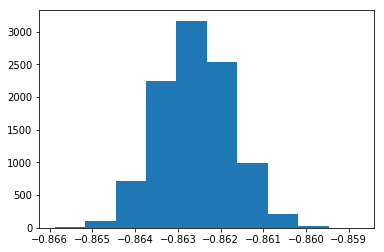

In [36]:
# Create a numpy array with p_diffs
p_diffs = np.array(p_diffs)

#Create a histogram of the sampling distribution from the numpy array
plt.hist(p_diffs);


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

(array([    5.,    59.,   319.,  1125.,  2340.,  2924.,  2075.,   904.,
          214.,    35.]),
 array([-0.00340887, -0.00277585, -0.00214284, -0.00150983, -0.00087682,
        -0.00024381,  0.0003892 ,  0.00102221,  0.00165523,  0.00228824,
         0.00292125]),
 <a list of 10 Patch objects>)

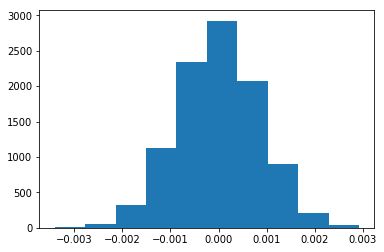

In [37]:
# Simulate distribution under the null hypothesis
null_values = np.random.normal(0, p_diffs.std(), p_diffs.size)

# Plot the null distribution
plt.hist(null_values)

In [38]:
# Compute p-value
(null_values > p_new_minus_p_old).mean()

0.8004

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value computed in part j is called the p-value, in this case the p-value is 0.8004, and it is a measure of the probability that we will observe the statistic given the null hypothesis to be true.  So we have about an 80% likelihood of recording a difference in conversion rates for two pages that in fact did not impacted conversion rates the same.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [39]:
# import statsmodels.api as sm # we did this at the top
# total number of rows describing old page and then new page
n_old = df.query('landing_page == "old_page"').user_id.nunique()
n_new = df.query('landing_page == "new_page"').user_id.nunique()

# new dataframes for old page and new page
old =  df.query('landing_page == "old_page"')
new = df.query('landing_page == "new_page"')

# number of conversions for old page and new page
convert_old = old.query('converted == "1"').user_id.nunique()
convert_new = new.query('converted == "1"').user_id.nunique()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [40]:
#z_score, p_value = sm.stats.proportions_ztest([count], [nobs])
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])

In [41]:
z_score

1.3878373223815128

In [42]:
p_value

0.16518658707329537

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score is positive but less than two and the p-value is low, so I am rejecting the null hypothesis that there will be no difference in conversion rates between the old and new pages.  This p-value is higher than the one I calculated in part j, but they are both low, so my conclusions remainsthe same.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Simple linear regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df['intercept'] = 1

In [35]:
# creates a new column that is a duplicate of the group column
# but replaces 'control' with '0' and 'treatment' with '1'
df['ab_page'] = df['group'].map({'treatment': 1, 'control': 0})

In [36]:
#create dummy variable
df['dummy_landing_page'] = df.landing_page.map({'new_page':0, 'old_page':1})

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
# lm stands for linear model and OLS stands for ordinary least squares
lm = sm.OLS(df['converted'], df[['intercept', 'ab_page']])
results = lm.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.530
Date:                Sat, 02 Feb 2019   Prob (F-statistic):              0.216
Time:                        05:07:14   Log-Likelihood:                -86476.
No. Observations:              294478   AIC:                         1.730e+05
Df Residuals:                  294476   BIC:                         1.730e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    142.325      0.000       0.119       0.122
ab_page       -0.0015      0.001     -1.237      0.216      -0.004       0.001
==============================================================================
Omnibus:                   127167.100   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           419292.014
Skew:                           2.344   Prob(JB):                         0.00
Kurtosis:                       6.493   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value is 0.216.  This is moderately low, so there is correlation between conversion and landing page.  The p-value calculated with the linear regression model is different from the p-value in part II, because in part II we were wanting to know whether there was any difference at all in conversion rate for the old page or the new page.  We didn't care whether the new page was correlated with a higher or lower conversion rate, we were just testing the likelihood of a different converstion rate.  With the linear regression, we were testing the likelihood of the new page having a higher conversion rate.  The p-value for the two-tailed test should be twice the value of one minus the p-value for the one-tailed test.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Increasing the number of independent variables may increases opportunities for variance, outliers, correlated errors, multicollinearity, or non-linear relationships.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [39]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
countries2_df = pd.get_dummies(countries_df, columns=['country']);
countries2_df.head()

,user_id,country_CA,country_UK,country_US
0,834778,0,1,0
1,928468,0,0,1
2,822059,0,1,0
3,711597,0,1,0
4,710616,0,1,0


In [41]:
# Add the countries dummy columns to the first dataframe with join using the user_id column
# append did not work for me here, it needs to be join
df2 = df.set_index('user_id').join(countries2_df.set_index('user_id'))
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,dummy_landing_page,country_CA,country_UK,country_US
user_id,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,0,1
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,0,1
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0,1
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,0,1
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,0,1


In [42]:
# linear regression looking at the effect of country on conversion rate
lm2 = sm.OLS(df2['converted'], df2[['intercept', 'country_UK', 'country_US']])
results2 = lm2.fit()

In [43]:
# summary of results
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.291
Date:                Sat, 02 Feb 2019   Prob (F-statistic):              0.275
Time:                        05:07:14   Log-Likelihood:                -86476.
No. Observations:              294478   AIC:                         1.730e+05
Df Residuals:                  294475   BIC:                         1.730e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1159      0.003     43.284      0.000       0.111       0.121
country_UK     0.0047      0.003      1.600      0.110      -0.001       0.010
country_US     0.0037      0.003      1.339      0.181      -0.002       0.009
==============================================================================
Omnibus:                   127166.345   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           419286.862
Skew:                           2.344   Prob(JB):                         0.00
Kurtosis:                       6.493   Cond. No.                         9.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Conclusions: The p-values for both the UK and the US are low, so we can reject the null hypothesis and say that there is correlation between conversion rate and country.  If the web page is very famous, people in each of the three countries could be converting because they heard people in other countries were using this service, so it is reasonable to look at a variance inflation factor.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

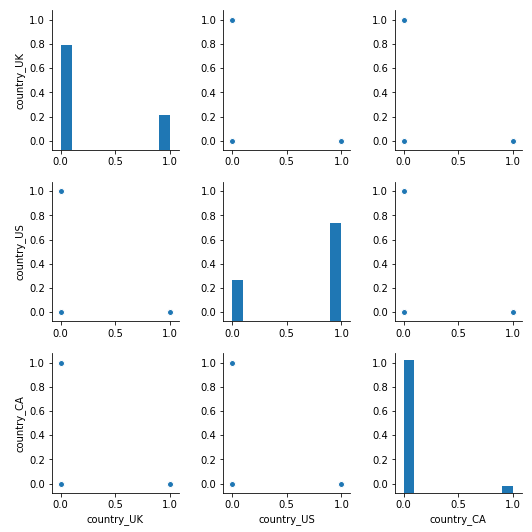

In [44]:
sns.pairplot(df2[['country_UK', 'country_US', 'country_CA']]);

In [48]:
# fit model and display a summary of results
lm2 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'country_US', 'country_CA']])
results = lm2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366238
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              215706.3094
Date:               2019-02-02 05:13 BIC:              215748.6812
No. Observations:   294478           Log-Likelihood:   -1.0785e+05
Df Model:           3                LL-Null:          -1.0785e+05
Df Residuals:       294474           LLR p-value:      0.24869    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9800    0.0127  -156.4758  0.0000  -2.0048  -1.9552
ab_page      -0.0140    0.0114    -1.2335  0.2174  -0.0363   0.0082
country_US   -0.0093    0.0132    -0.7014  0.4830  -0.0352   0.0166
country_CA   -0.0449    0.0282    -1.5963  0.1104  -0.1001   0.0102
==================================================================

"""

The new page does not make a significant difference in conversion traffic.  Based on the fit of the linear regression model comparing different countries, the lack of any signficant difference between the old page and new page appears to be the case regardless of country.  We planned to keep the old page unless the new page was a significant improvement, so we should keep the old page.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [49]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0